# Data Processing & Summarization
# Descriptive statistic

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import spatial, stats
import statsmodels.api as sm
import numpy as np
import seaborn as sns

## Outliers
Here we consider ways in which we can identify outliers and the effect that these have.

1. Load the [data on properties of cars](https://moodle.city.ac.uk/pluginfile.php/2782665/mod_page/content/21/accord_sedan.csv) into a pd dataframe
2. Plot suitable graphs to show the distributions and help indicate outliers of priceand mileage (e.g. with boxplots) and their joint distribution (e.g. with a scatterplot)
3. (Visually) identify the outliers.
4. Add two new columns to the dataframe called `isOutlierPrice`, `isOutlierMileage`. For the `price` column, calculate the mean and standard deviation. Use the standard deviation and mean to try to identify outliers for these two variables and mark them with a `1` in the `isOutlierPrice` and `isOutlierMilage` columns. For example, you could look for values that are more than 2 standard deviations away from the mean. You can either use a loop and the Pandas `loc()` function to access and update values, or you can use the more efficient Pandas methods that are summarised in the Cheat Sheet that you used a bit of last week.
5. Show these "outliers" using a different colour (hue) in the plot. Are these what you would consider outliers? Observe whether they are the same as you would mark them.
6. **Optional**: Use Mahalanobis distance to identify 2D outliers. You can compute a 2D Mahalanobis distance for each row using a `scipy's cdist()` function). For this, you need to find the 2D mean vector and find the 2D Mahalanobis distance of each point to this mean vector. Finally, colour all the points according to their Mahalanobis Distance. Here is a `matplotlib example that uses colouring` and choose an [appropriate colour map](http://matplotlib.org/examples/color/colormaps_reference.html) here (use a sequential lightness-based colour scheme). Compare your outlier observation step-3 to the resulting scatterplot.

In [2]:
cars = pd.read_csv("accord_sedan.csv", header = 0)
cars

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic
...,...,...,...,...,...,...
412,12456,67564,2006,lx,4 Cyl,Automatic
413,10995,69775,2006,ex,4 Cyl,Automatic
414,16000,77997,2006,exl,4 Cyl,Automatic
415,14700,61892,2006,ex,4 Cyl,Automatic


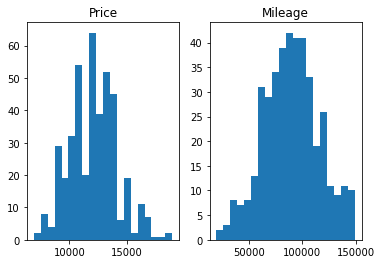

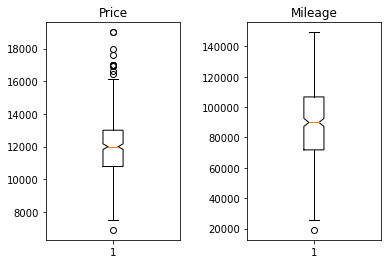

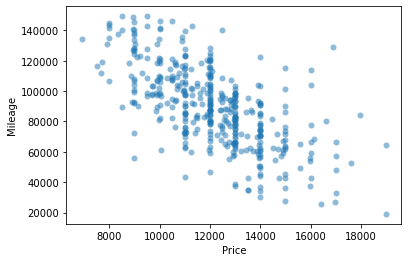

In [3]:
# Histograms
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(cars['price'], 20)
ax1.set_title('Price')
ax2.hist(cars['mileage'], 20)
ax2.set_title('Mileage')
plt.show()

# Box plot
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(cars['price'], True)
ax1.set_title('Price')
ax2.boxplot(cars['mileage'], True)
ax2.set_title('Mileage')
plt.subplots_adjust(wspace = 0.5)
plt.show()

# Scatter plot
plt.scatter(cars.price, cars.mileage, linewidth=0, alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.show()

In [4]:
# Create new columns, filled with 0s
cars['isOutlierPrice'] = 0 
cars['isOutlierMileage'] = 0

# Calculate the mean and standard deviations
meanPrice = cars['price'].mean()
stdDevPrice = cars['price'].std()
meanMil = cars['mileage'].mean()
stdDevMil = cars['mileage'].std()

# Use a filter. More efficent not to explictly use loop. Use loc as before,
# But filter rows on the outlier condition
cars.loc[abs(cars['price'] - meanPrice) > 2 * stdDevPrice,'isOutlierPrice'] = 1
cars.loc[abs(cars['mileage'] - meanMil) > 2 * stdDevMil,'isOutlierMileage'] = 1

In [5]:
# More alternative way to identify outliers

# Use a loop. There are many ways of even doing that. The enumerate() function returns
# the index (i) AND the value (val). The second one uses the loop differently
#To avoid copy warnings, use loc which ensures you access the dataframe directly
for i,val in enumerate(cars['price']):
    if abs(val - meanPrice) > 2 * stdDevPrice:
        cars.loc[i,"isOutlierPrice"] = 1

for i in range(len(cars)):
    if abs(cars.loc[i,"isOutlierMileage"] - meanMil) > 2 * stdDevMil:
        cars.loc[i,"isOutlierMileage"] = 1
        
# Uses numpy where() function where you give it a condition
cars['isOutlierPrice'] = np.where(abs(cars['price'] - meanPrice) > 2 * stdDevPrice, 1, 0)
cars['isOutlierMileage'] = np.where(abs(cars['mileage'] - meanMil) > 2 * stdDevMil, 1, 0)

In [6]:
#This counts the unique values
print('Price outliers:', Counter(cars['isOutlierPrice']))
print('Mileage outliers:', Counter(cars['isOutlierMileage']))

Price outliers: Counter({0: 400, 1: 17})
Mileage outliers: Counter({0: 393, 1: 24})


Colours are commonly specified in hexadecimal, with pairs of 0-f values corresponding to red, green and blue (and optionally opacity). So #ff0000 is red, #00ff00 is green and #0000ff is blue (a fourth pair of hexadecimal values will change the transparency) [See this](https://www.w3schools.com/colors/colors_picker.asp).

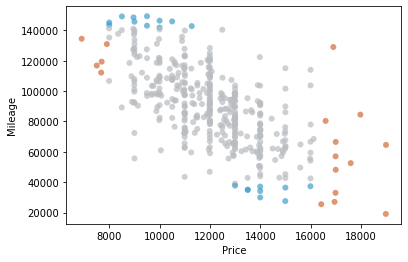

In [7]:
# First create an empty list
colorColumn = []

# We make use of the HEX color codes
# Adobe Color CC is a nice resource to find colors (https://color.adobe.com/)
for i in range(len(cars)):
    if cars["isOutlierPrice"][i] == 1:
        colorColumn.append("#D06B36ff") # orange color
    elif cars["isOutlierMileage"][i] == 1:
        colorColumn.append("#40A0C977") # a blueish color
    else:
        colorColumn.append("#B9BCC077") # gray
        
# Scatter plot
plt.scatter(cars.price, cars.mileage, c=colorColumn, linewidth=0, alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.show()

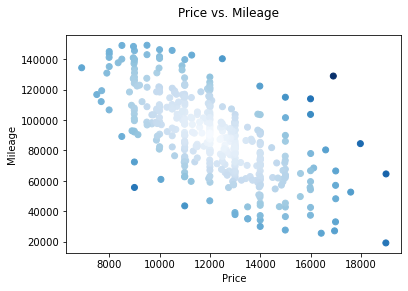

In [8]:
# Get our 2D vectors (2 columns)
rowVectors = cars[["price", "mileage"]]

# We calculate the "mean vector"
meanVector = [[meanPrice, meanMil]]

mahalanobisDistances = spatial.distance.cdist(rowVectors, meanVector, 'mahalanobis')

# We create a new figure where we use a color mapping and use the computed mahalanobis distances 
# As the mapping value
plt.xlabel('Price')
plt.suptitle('Price vs. Mileage')
plt.ylabel('Mileage')
plt.scatter(cars.price, cars.mileage , c = mahalanobisDistances, cmap = plt.cm.Blues)

## Q-Q Plots
Q-Q Plots are designed for visually comparing your distributions to known distributions. Here we use statsmodels `qqplot()` function to compare the distributions of our data to known theoretical distributions.

1. Download [the csv data file from WHO on Tuberculosis (from Week01)](https://moodle.city.ac.uk/pluginfile.php/2782665/mod_page/content/21/TB_burden_countries_2014-09-29.csv). Information on the data can be found on [WHO's web page](http://www.who.int/tb/country/data/download/en/). You may need to replace missing values before you start.
2. Pick one of the columns from the Tuberculosis data and compare to a normal distribution. See [this link for various distributions and functions to use in data sampling and in particular consider sampling](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html) from the normal distribution in this case as [explained in this example](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html). Use the [statsmodels qqplot()](http://statsmodels.sourceforge.net/devel/generated/statsmodels.graphics.gofplots.qqplot.html) function to generate a qqplot. Compare this to a histogram representation.

In [9]:
tbDF = pd.read_csv("TB_burden_countries_2014-09-29.csv", header = 0)
tbDF

,country,iso2,iso3,iso_numeric,g_whoregion,year,e_pop_num,e_prev_100k,e_prev_100k_lo,e_prev_100k_hi,...,e_inc_tbhiv_100k,e_inc_tbhiv_100k_lo,e_inc_tbhiv_100k_hi,e_inc_tbhiv_num,e_inc_tbhiv_num_lo,e_inc_tbhiv_num_hi,source_tbhiv,c_cdr,c_cdr_lo,c_cdr_hi
0,Afghanistan,AF,AFG,4,EMR,1990,11731193,327.0,112.0,655.0,...,0.35,0.22,0.52,41.0,25.0,60.0,Model,20.0,13.0,32.0
1,Afghanistan,AF,AFG,4,EMR,1991,12612043,359.0,172.0,613.0,...,0.36,0.19,0.58,45.0,24.0,73.0,Model,97.0,77.0,120.0
2,Afghanistan,AF,AFG,4,EMR,1992,13811876,387.0,169.0,693.0,...,0.37,0.19,0.62,51.0,26.0,86.0,Model,NaN,NaN,NaN
3,Afghanistan,AF,AFG,4,EMR,1993,15175325,412.0,186.0,724.0,...,0.38,0.20,0.63,58.0,30.0,95.0,Model,NaN,NaN,NaN
4,Afghanistan,AF,AFG,4,EMR,1994,16485018,431.0,199.0,751.0,...,0.40,0.21,0.64,65.0,35.0,100.0,Model,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898,Zimbabwe,ZW,ZWE,716,AFR,2008,12784041,445.0,56.0,1228.0,...,574.00,447.00,716.00,73000.0,57000.0,92000.0,Surveillance,40.0,32.0,51.0
4899,Zimbabwe,ZW,ZWE,716,AFR,2009,12888918,423.0,49.0,1192.0,...,531.00,408.00,670.00,68000.0,53000.0,86000.0,Surveillance,50.0,40.0,65.0
4900,Zimbabwe,ZW,ZWE,716,AFR,2010,13076978,438.0,70.0,1136.0,...,480.00,371.00,603.00,63000.0,48000.0,79000.0,Surveillance,53.0,43.0,69.0
4901,Zimbabwe,ZW,ZWE,716,AFR,2011,13358738,458.0,93.0,1107.0,...,433.00,335.00,543.00,58000.0,45000.0,73000.0,Surveillance,48.0,38.0,62.0


In [10]:
# Replace missing values with mean()
tbDF.fillna(tbDF.mean(), inplace=True)

/Users/nathanbui/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


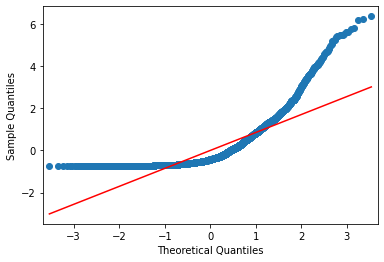

In [11]:
# Option 1: Statsmodel's qqplot. "fit" tells it to work out the parameters of the distribution
sm.qqplot(tbDF.e_prev_100k_hi, dist=stats.norm, fit=True, line = 'r')
plt.show()

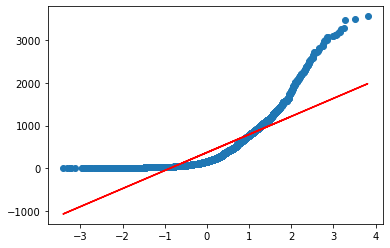

In [12]:
# Option 2: Same plot, but using scatterplot (with ranked values)

# Sort the data
sorted_data = sorted(tbDF.e_prev_100k_hi)

# Generate as many random points (drawn from a normal distribution) as data points in your data, and sort them
normal_distr = np.random.normal(size=len(sorted_data))
sorted_normal_distr = sorted(normal_distr)

# Make a scatterplot
plt.scatter(sorted_normal_distr,sorted_data)

# Calculate a regression line and draw it on
m, b = np.polyfit(sorted_normal_distr ,sorted_data, 1)
plt.plot(normal_distr, m* normal_distr + b, c='red')
plt.show()

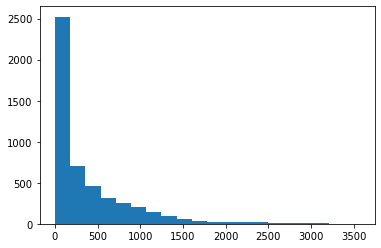

In [13]:
ax2 = plt.hist(tbDF.e_prev_100k_hi, 20)
plt.show()

The qqplots suggest these are not normally distributed, because the point don't lie along a straight line. The histogram confirms this It's massively skewed to the left. This suggests something closer to a log distribution. Let's test this.

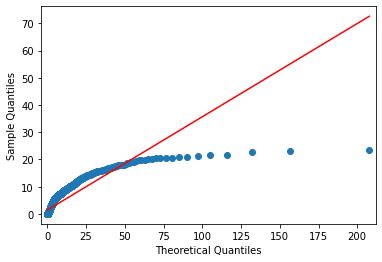

In [14]:
# Option 1: Statsmodel's qqplot, using "lognorm". "fit" tells it to work out the parameters of the distribution a
sm.qqplot(tbDF.e_prev_100k_hi, dist=stats.lognorm, fit=True, line = 'r')
plt.show()

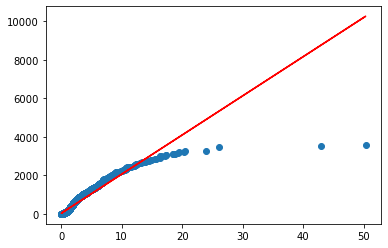

In [15]:
# Option 2: Scatterplot (with ranked values)
# Generate as many random points (drawn from a normal distribution) as data points in your data, and sort them
log_normal_distr = np.random.lognormal(size=len(sorted_data))
sorted_log_normal_distr=sorted(log_normal_distr)

# Make a scatterplot
plt.scatter(sorted_log_normal_distr,sorted_data)

# Calculate a regression line and draw it on
m, b = np.polyfit(sorted_log_normal_distr, sorted_data, 1)
plt.plot(log_normal_distr,m* log_normal_distr + b, c='red')
plt.show()

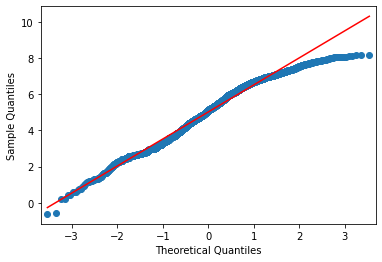

In [16]:
# Option 3: We transform our variable (by 'applying' np.log()) and test against a NORMAL distribution
loggedColumnToTest=tbDF.e_prev_100k_hi.apply(np.log)
fig = sm.qqplot(loggedColumnToTest, stats.norm, line = 'r')

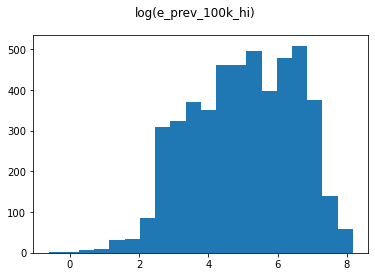

In [17]:
# Histogram
plt.suptitle("log(e_prev_100k_hi)")
plt.hist(loggedColumnToTest, 20);

## Distributions & Sampling & Robust Statistics
During the lectures, we discussed on how we make inferences based on the samples we get from distributions and how volatile they can be. We looked into this interactive tool to discuss how much descrtiptive statistics can vary and tell a different story regarding the underlying data and the models that they follow. You can take some time to play with this [interactive tool to observe that](http://onlinestatbook.com/stat_sim/sampling_dist/index.html).

In the first part of this example, we'll get samples of varying sizes from different distributions and observe how the descriptive statistics change.

1. Randomly sample data from a known distribution (you can choose to [sample from a normal distribution](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) as we did on Step-2 above) with varying sample sizes of n = 5, 10, 100 and varying s = standard deviations (try 3 different values, you can have a look at this Wikipedia figure to get inspiration on the [standard deviation measures](https://en.wikipedia.org/wiki/Normal_distribution#/media/File:Normal_Distribution_PDF.svg)) and make observations on how well the "underlying distribution" is preserved in the sampled data you are drawing from.
    In order to do this:

    - Sample n data points from a distribution for a given variance s.
    - Compute the mean, standard deviation, skewness and kurtosis statistics for each sampling round
    - Repeat these two steps with varying n and varying s, i.e., covering all the n vs. s combinations, 3 x 3 = 9 combinations.
    - Once you save all the values above, observe how they change over the different conditions (i.e., the varying sample size and varying standard deviation you set for the underlying distribution) you are setting.
    You can even consider visualising that data if you will.
2. **(Optional)** Also try the above for a different underlying distribution such as a Poisson. The only part that needs to change is the part you sample the data and of course the underlying parameters for a Poisson distribution -- refer to this link for the Scipy function for a [Poisson distribution](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.poisson.html).
3. **(Optional)** And also try the same process to generate a simple bimodal distribution (a link to a Wikipedia page with an image of a [bi-Modal distribution](https://en.wikipedia.org/wiki/Multimodal_distribution)) and observe how the statistics vary this time. Hint: you can generate a bimodal distribution as a mixture of two Gaussion distributions with non-overlapping parameters.
Here, we'll briefly look into how robust statistics can vary compared to their non-robust counterparts. As we discussed in the lectures, robust statistics are statistics that are more resilient to outliers and can provide cleaner estimations in cases where the data has non-standard behaviour.

1. Choose a number of columns with different shapes, for instance, "e_prev_100k_hi" is left skewed or some columns where the variation is high or you notice potential outliers. You can make use of a series of boxplots to exploratively analyse the data for outliers, a link [here for boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html).
2. For the chosen columns, estimate both the conventional and the robust descriptive statistics and compare. Some couples to try are: mean vs. median, standard deviation vs. inter-quartile range, standard deviation vs.median absolute deviation (statsmodels have a [function for MAD](http://www.statsmodels.org/dev/rlm.html)). Observe how these pairs deviate from each other based on the characteristics of the underlying data.

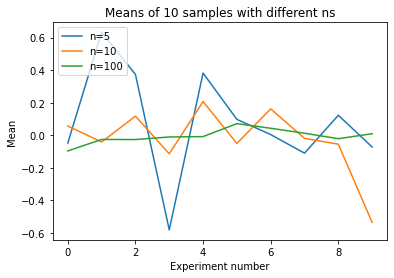

In [18]:
# Initial sample size, mean and spread 
sampleSize=[5,10,100]
meanParam=0
spreadParam=0.5

# Empty list to store our means
meanEstimations = []

# For each sample size, we will run 10 times
# Store the mean in 2 dimmetions array (or list of list)
for i in range (len(sampleSize)):
    meanEstimations.append([])
    for j in range (10):
        sampledArray = np.random.normal(meanParam, spreadParam, sampleSize[i])
        meanEstimations[i].append(np.mean(sampledArray))
        
# Plot them
series=[] # To store the series names
for i in range (len(sampleSize)):
    plt.plot(meanEstimations[i])
    series.append("n=" + str(sampleSize[i]))
    
plt.legend(series, loc='upper left')
plt.title("Means of 10 samples with different ns")
plt.xlabel("Experiment number")
plt.ylabel("Mean")
plt.show()

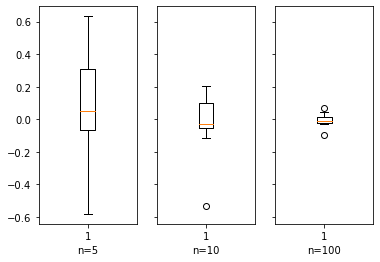

In [19]:
f, axes = plt.subplots(1, len(sampleSize), sharey=True)
for i in range (len(sampleSize)):
    axes[i].boxplot(meanEstimations[i])
    axes[i].set_xlabel("n=" + str(sampleSize[i]))
plt.show()

Note that the higher n, the more stable the means, because we're sampling a greater amount of the 'population'. The green line in the line graph has largest sample size (n=100) and is the most constant. Try running the code (above) again to see how it's changing. Analyses are more robust when we have larger sample sizes.

The boxplots confirm that the spread of the means is smaller the more samples are picked. Boxplots show this very effectively.

In [28]:
# Create row names array
rownames=[]
for i in range (len(sampleSize)):
    rownames.append("n=" + str(sampleSize[i]))
    
experimentMeansDF = pd.DataFrame(meanEstimations, index=rownames) # Turn 2-D list into dataframe
experimentMeansDF = experimentMeansDF.transpose()
experimentMeansDF

,n=5,n=10,n=100
0,-0.048062,0.056454,-0.096492
1,0.632527,-0.041476,-0.025734
2,0.373815,0.117073,-0.026488
3,-0.581405,-0.114215,-0.010667
4,0.381669,0.206610,-0.008192
5,0.097342,-0.050096,0.071156
6,0.004026,0.162119,0.042792
7,-0.109899,-0.019152,0.012338
8,0.122613,-0.054926,-0.021272
9,-0.072266,-0.535769,0.009399


In [29]:
tidyExperiment=experimentMeansDF.melt(var_name="Experiment", value_name="Means")
tidyExperiment.head()

,Experiment,Means
0,n=5,-0.048062
1,n=5,0.632527
2,n=5,0.373815
3,n=5,-0.581405
4,n=5,0.381669


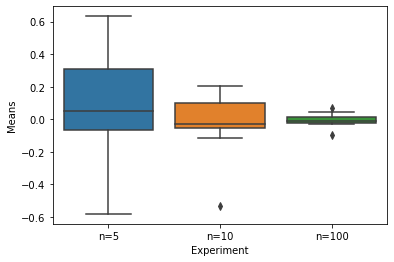

In [31]:
sns.boxplot(data=tidyExperiment, x="Experiment", y="Means");

### Robust statistics

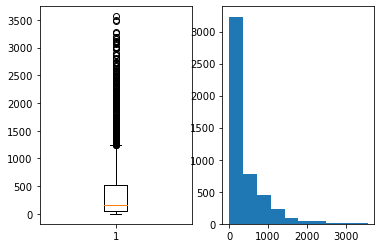

In [33]:
# Plots
f, ax = plt.subplots(1, 2)
ax[0].boxplot(tbDF.e_prev_100k_hi);
ax[1].hist(tbDF.e_prev_100k_hi);

## Correlation Analysis
We will be analysing a data set made available by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html) a good place to find example data sets. The data, Communities in the US., combines socio-economic data from the 1990 Census, law enforcement data from the 1990 Law Enforcement Management and Admin Stats survey, and crime data from the 1995 FBI UCR. We provide two versions of the data, [a problematic one with some missing values](https://moodle.city.ac.uk/pluginfile.php/2782674/mod_page/content/46/censusCrime.csv), and a [clean version](https://moodle.city.ac.uk/pluginfile.php/2782674/mod_page/content/46/censusCrimeClean.csv)  where the problematic columns have been removed. Detailed information on column names [can be found here](https://moodle.city.ac.uk/pluginfile.php/2782674/mod_page/content/46/communitiesNames.txt).
Here we investigate how we can perform correlation analysis using Python. Let's start will looking about socialdemographic variables correlate to crime levels.

1. Load the [Communities in the US (cleaned version)](https://moodle.city.ac.uk/pluginfile.php/2782674/mod_page/content/46/censusCrimeClean.csv) into a Pandas dataframe.
2. Choose two columns as save as variables. You can choose any but an interesting pair could be "medIncome" and "ViolentCrimesPerPop".
3. Perform a [Pearson correlation](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr) and note the correlation value.
4. Perform a [Spearman correlation](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) computation and note the correlation value.
5. Comment on the differences / similarities in relation to a scatterplot visualisation of the two columns.
6. Have a go at comparing other columns to crimes. You might want to select some columns and calculate correlation coefficients and draw scatterplots in a loop

In [42]:
# Load the dataset and then check
census = pd.read_csv('censusCrimeClean.csv')
census

,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,ViolentCrimesPerPop
0,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.00,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.20
1,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.00,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.67
2,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.00,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.43
3,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.00,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.12
4,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.00,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,...,0.00,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.09
1990,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,...,0.00,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.45
1991,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,...,0.02,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.23
1992,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,...,0.01,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.19


In [43]:
# Get the colums
medIncome = census.medIncome
violentCrimesPerPop = census.ViolentCrimesPerPop

# Do Peason correlation
corrPearson, pValPearson = stats.pearsonr(medIncome, violentCrimesPerPop)
print ("Pearson's correlation is", corrPearson, "with a p-value of",pValPearson)

# Do Spearman correlation
corrSpearman, pValSpearman = stats.spearmanr(medIncome, violentCrimesPerPop)
print ("Spearman's correlation is", corrSpearman, "with a p-value of",pValSpearman)

Pearson's correlation is -0.4242206167261274 with a p-value of 6.334424808039891e-88
Spearman's correlation is -0.482169950997556 with a p-value of 1.2978853095169542e-116


There's a small difference between the two computations. Spearman's is higher. This is because Spearman's rank-based approach is better at capturing non-linear relationships. The p-values are the probabilities that correlation of the population is not correlated (i.e. with a null-hypothesis that the population are not correlated). This is very low, indicating that the effect and sample size is high enough to be confident statistically significant.

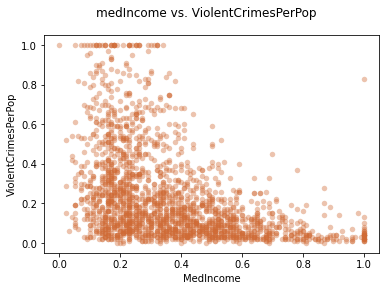

In [44]:
plt.suptitle('medIncome vs. ViolentCrimesPerPop')
plt.xlabel('MedIncome')
plt.ylabel('ViolentCrimesPerPop')
plt.scatter(medIncome, violentCrimesPerPop, c = "#D06B36", s = 30, alpha = 0.4, linewidth=0);

The scatterplot shows a negative correlation, but it doesn't look linear. This is perhaps why the Spearman's correlation shows a slightly higher correlation.

In [45]:
print('Mean:', tbDF.e_prev_100k_hi.mean(),'Median', tbDF.e_prev_100k_hi.median())
print('Std:', tbDF.e_prev_100k_hi.std(),'IQR', stats.iqr(tbDF.e_prev_100k_hi))
print('Std:', tbDF.e_prev_100k_hi.std(),'MAD', sm.robust.scale.mad(tbDF.e_prev_100k_hi))

Mean: 378.13700122649203 Median 165.0
Std: 500.49692360689403 IQR 479.0
Std: 500.49692360689403 MAD 210.52951502779547


In [55]:
# Calculate the correlation
corr = census.corr()
corr

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,ViolentCrimesPerPop
fold,1.000000,-0.007552,0.035488,0.003524,-0.004436,-0.001317,0.000915,-0.000151,0.007080,-0.006858,...,-0.019733,-0.000195,-0.025403,-0.021956,-0.035202,-0.027938,0.017846,-0.012570,-0.000541,-0.032577
population,-0.007552,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,...,0.651797,0.172731,-0.125133,-0.123691,0.001610,-0.089638,0.713652,0.231897,0.270356,0.367157
householdsize,0.035488,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,...,-0.043011,0.311107,-0.049253,-0.057842,-0.103109,-0.003277,-0.015078,-0.004072,-0.051506,-0.034923
racepctblack,0.003524,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,...,0.167133,-0.098114,0.093494,-0.045646,0.056358,-0.002894,0.149758,0.095053,0.147023,0.631264
racePctWhite,-0.004436,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,...,-0.238925,-0.372924,0.113798,0.165285,-0.019677,0.032415,-0.131389,-0.337458,-0.215636,-0.684770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PctSameState85,-0.027938,-0.089638,-0.003277,-0.002894,0.032415,-0.198279,0.000202,-0.150555,-0.317647,-0.274540,...,-0.079417,-0.137901,0.761741,0.670972,0.742042,1.000000,-0.104403,-0.012166,-0.042424,-0.019459
LandArea,0.017846,0.713652,-0.015078,0.149758,-0.131389,-0.001084,0.011634,0.025736,0.062476,0.031632,...,0.425952,-0.048845,-0.069273,-0.116901,-0.062989,-0.104403,1.000000,-0.170856,0.007699,0.196800
PopDens,-0.012570,0.231897,-0.004072,0.095053,-0.337458,0.389944,0.370103,-0.095749,0.119725,0.045979,...,0.238896,0.614772,-0.221341,0.020701,0.118082,-0.012166,-0.170856,1.000000,0.587804,0.281390
PctUsePubTrans,-0.000541,0.270356,-0.051506,0.147023,-0.215636,0.296921,0.078366,-0.173279,-0.023507,-0.040419,...,0.239042,0.401711,-0.175459,0.192367,0.081260,-0.042424,0.007699,0.587804,1.000000,0.153829


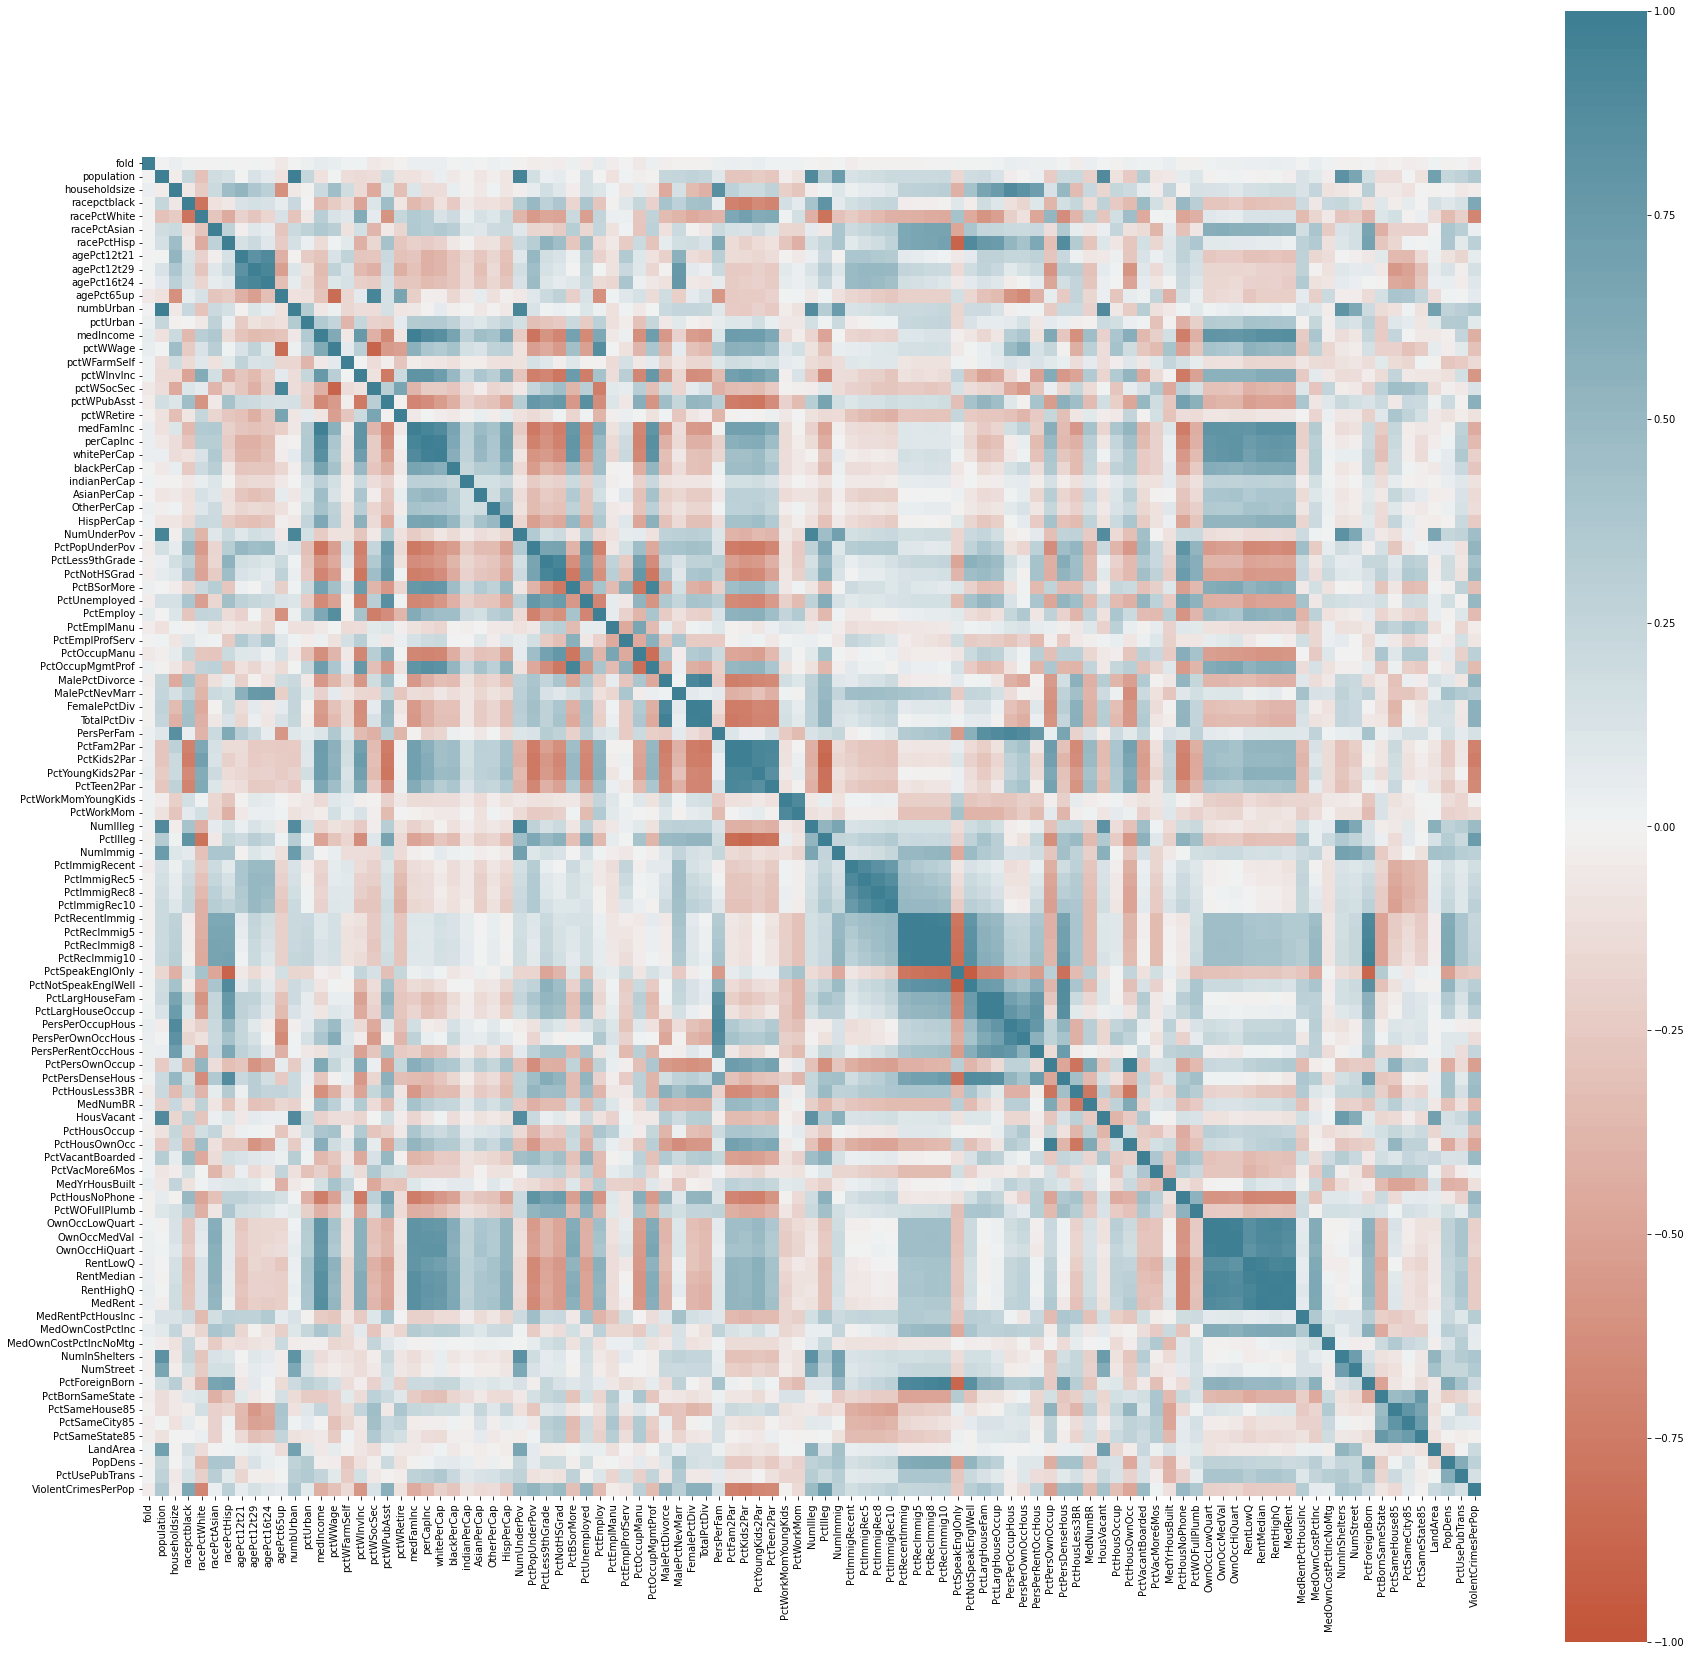

In [56]:
# Show the correlation on a hearmap
plt.figure(figsize = (30,30))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Now we take only "ViolentCrimesPerPop" and check the correlation of others to it

In [60]:
# Get the column
corr_crimes=corr[['ViolentCrimesPerPop']]

# Sort by the amount of correlation
corr_crimes = corr_crimes.sort_values(by ='ViolentCrimesPerPop', ascending=False)
corr_crimes

,ViolentCrimesPerPop
ViolentCrimesPerPop,1.000000
PctIlleg,0.737957
racepctblack,0.631264
pctWPubAsst,0.574665
FemalePctDiv,0.556032
...,...
PctTeen2Par,-0.661582
PctYoungKids2Par,-0.666059
racePctWhite,-0.684770
PctFam2Par,-0.706667


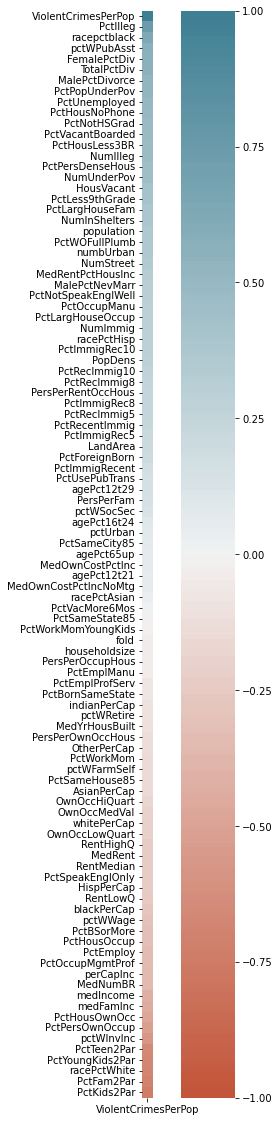

In [61]:
# Show the heatmap
plt.figure(figsize = (10,20))
ax = sns.heatmap(
    corr_crimes, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

This let's see which variables are most correlated with violent crime. This might help us choose variables to build a model by telling us (a) which variables are most likely to be good predictors and (b) which variables are likely to be simply proxies for others (so we don't include them).

Let's go back to all the correlations (i.e. not just for correlations with violent crime). What if we wanted to automatically identify the pairs of variables with the strongest correlation? Well, of course we can do that!

Here, I'm going to restructure ("tidy") the correlation matrix, so that for each row, I have a pair of variables and their correlation. Then we can sort this by the amount of correlation.

In [64]:
# Make a copy
corr_copy = corr.copy()

#In the correlation matrix, each *row* has the variable name
#as the index, but we need this to be a new column
corr_copy.index.name = 'var1'
corr_copy.reset_index(inplace=True)
corr_copy

,var1,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,ViolentCrimesPerPop
0,fold,1.000000,-0.007552,0.035488,0.003524,-0.004436,-0.001317,0.000915,-0.000151,0.007080,...,-0.019733,-0.000195,-0.025403,-0.021956,-0.035202,-0.027938,0.017846,-0.012570,-0.000541,-0.032577
1,population,-0.007552,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,...,0.651797,0.172731,-0.125133,-0.123691,0.001610,-0.089638,0.713652,0.231897,0.270356,0.367157
2,householdsize,0.035488,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,...,-0.043011,0.311107,-0.049253,-0.057842,-0.103109,-0.003277,-0.015078,-0.004072,-0.051506,-0.034923
3,racepctblack,0.003524,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,...,0.167133,-0.098114,0.093494,-0.045646,0.056358,-0.002894,0.149758,0.095053,0.147023,0.631264
4,racePctWhite,-0.004436,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,...,-0.238925,-0.372924,0.113798,0.165285,-0.019677,0.032415,-0.131389,-0.337458,-0.215636,-0.684770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,PctSameState85,-0.027938,-0.089638,-0.003277,-0.002894,0.032415,-0.198279,0.000202,-0.150555,-0.317647,...,-0.079417,-0.137901,0.761741,0.670972,0.742042,1.000000,-0.104403,-0.012166,-0.042424,-0.019459
97,LandArea,0.017846,0.713652,-0.015078,0.149758,-0.131389,-0.001084,0.011634,0.025736,0.062476,...,0.425952,-0.048845,-0.069273,-0.116901,-0.062989,-0.104403,1.000000,-0.170856,0.007699,0.196800
98,PopDens,-0.012570,0.231897,-0.004072,0.095053,-0.337458,0.389944,0.370103,-0.095749,0.119725,...,0.238896,0.614772,-0.221341,0.020701,0.118082,-0.012166,-0.170856,1.000000,0.587804,0.281390
99,PctUsePubTrans,-0.000541,0.270356,-0.051506,0.147023,-0.215636,0.296921,0.078366,-0.173279,-0.023507,...,0.239042,0.401711,-0.175459,0.192367,0.081260,-0.042424,0.007699,0.587804,1.000000,0.153829


In [65]:
# Now we will melt the data
#Now we "melt" the table, preserving the column we've just made.
corr_pair=corr_copy.melt(id_vars=['var1'])
corr_pair

,var1,variable,value
0,fold,fold,1.000000
1,population,fold,-0.007552
2,householdsize,fold,0.035488
3,racepctblack,fold,0.003524
4,racePctWhite,fold,-0.004436
...,...,...,...
10196,PctSameState85,ViolentCrimesPerPop,-0.019459
10197,LandArea,ViolentCrimesPerPop,0.196800
10198,PopDens,ViolentCrimesPerPop,0.281390
10199,PctUsePubTrans,ViolentCrimesPerPop,0.153829


In [67]:
#Now we just replace the some of the column names with more sensible ones
corr_pair.rename(columns={'variable': 'var2','value': 'corr'}, inplace=True)
corr_pair

,var1,var2,corr
0,fold,fold,1.000000
1,population,fold,-0.007552
2,householdsize,fold,0.035488
3,racepctblack,fold,0.003524
4,racePctWhite,fold,-0.004436
...,...,...,...
10196,PctSameState85,ViolentCrimesPerPop,-0.019459
10197,LandArea,ViolentCrimesPerPop,0.196800
10198,PopDens,ViolentCrimesPerPop,0.281390
10199,PctUsePubTrans,ViolentCrimesPerPop,0.153829


In [69]:
#Now, we remove rows where var1 and var2 are the same (these are always 1)
corr_pair.drop(corr_pair[corr_pair['var1']==corr_pair['var2']].index, inplace=True)
corr_pair

,var1,var2,corr
1,population,fold,-0.007552
2,householdsize,fold,0.035488
3,racepctblack,fold,0.003524
4,racePctWhite,fold,-0.004436
5,racePctAsian,fold,-0.001317
...,...,...,...
10195,PctSameCity85,ViolentCrimesPerPop,0.075558
10196,PctSameState85,ViolentCrimesPerPop,-0.019459
10197,LandArea,ViolentCrimesPerPop,0.196800
10198,PopDens,ViolentCrimesPerPop,0.281390


Now we can look at the distribution of the residuals and find the top ten most positive and negative correlations. If we're still interested in those that correlate with crime, we can specify this. We might also want to sort by the absolute correlation.

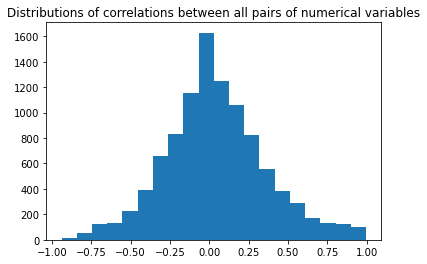

In [71]:
# Make a histogram
plt.hist(corr_pair['corr'],20)
plt.title("Distributions of correlations between all pairs of numerical variables");

In [73]:
#Now we sort the rows on the correlation
corr_pair=corr_pair.sort_values(by ='corr',ascending=False);

print("Top ten most positively correlated pairs of variables")
corr_pair.head(10)

Top ten most positively correlated pairs of variables


,var1,var2,corr
6019,PctRecImmig10,PctRecImmig8,0.995525
6119,PctRecImmig8,PctRecImmig10,0.995525
8261,OwnOccLowQuart,OwnOccMedVal,0.994481
8161,OwnOccMedVal,OwnOccLowQuart,0.994481
5917,PctRecImmig8,PctRecImmig5,0.993433
6017,PctRecImmig5,PctRecImmig8,0.993433
1112,population,numbUrban,0.993112
112,numbUrban,population,0.993112
8263,OwnOccHiQuart,OwnOccMedVal,0.991302
8363,OwnOccMedVal,OwnOccHiQuart,0.991302


In [74]:
print("Top ten most negatively correlated pairs of variables (in reverse order)")
corr_pair.tail(10)

Top ten most negatively correlated pairs of variables (in reverse order)


,var1,var2,corr
4596,PctIlleg,PctKids2Par,-0.870198
5196,PctKids2Par,PctIlleg,-0.870198
9353,PctSpeakEnglOnly,PctForeignBorn,-0.877793
6253,PctForeignBorn,PctSpeakEnglOnly,-0.877793
667,PctSpeakEnglOnly,racePctHisp,-0.890768
6167,racePctHisp,PctSpeakEnglOnly,-0.890768
1731,pctWWage,pctWSocSec,-0.897936
1431,pctWSocSec,pctWWage,-0.897936
6323,PctSpeakEnglOnly,PctNotSpeakEnglWell,-0.939369
6223,PctNotSpeakEnglWell,PctSpeakEnglOnly,-0.939369


In [76]:
# Add a column with the absolute correlation, so we can sort on
# Amount of correlation, regardless of the sign if we want
corr_pair['abs_corr']=abs(corr_pair['corr'])
# Sort on this
corr_pair=corr_pair.sort_values(by ='abs_corr',ascending=False)
corr_pair

,var1,var2,corr,abs_corr
6019,PctRecImmig10,PctRecImmig8,0.995525,0.995525
6119,PctRecImmig8,PctRecImmig10,0.995525,0.995525
8261,OwnOccLowQuart,OwnOccMedVal,0.994481,0.994481
8161,OwnOccMedVal,OwnOccLowQuart,0.994481,0.994481
5917,PctRecImmig8,PctRecImmig5,0.993433,0.993433
...,...,...,...,...
9050,PctSpeakEnglOnly,MedOwnCostPctIncNoMtg,0.000053,0.000053
4564,pctWRetire,PctKids2Par,-0.000013,0.000013
1964,PctKids2Par,pctWRetire,-0.000013,0.000013
6234,PctHousOccup,PctSpeakEnglOnly,0.000001,0.000001


In [77]:
print("Top ten most correlated pairs of variables with 'ViolentCrimesPerPop'")
corr_pair[corr_pair['var1']=='ViolentCrimesPerPop'].head(10)

Top ten most correlated pairs of variables with 'ViolentCrimesPerPop'


,var1,var2,corr,abs_corr
4645,ViolentCrimesPerPop,PctKids2Par,-0.738424,0.738424
5251,ViolentCrimesPerPop,PctIlleg,0.737957,0.737957
4544,ViolentCrimesPerPop,PctFam2Par,-0.706667,0.706667
504,ViolentCrimesPerPop,racePctWhite,-0.684770,0.684770
4746,ViolentCrimesPerPop,PctYoungKids2Par,-0.666059,0.666059
4847,ViolentCrimesPerPop,PctTeen2Par,-0.661582,0.661582
403,ViolentCrimesPerPop,racepctblack,0.631264,0.631264
1716,ViolentCrimesPerPop,pctWInvInc,-0.576324,0.576324
1918,ViolentCrimesPerPop,pctWPubAsst,0.574665,0.574665
4241,ViolentCrimesPerPop,FemalePctDiv,0.556032,0.556032


These last steps are really just to illustrate the fact that Python lets us restructure our data so we can do different analyses.

Remember that all we are doing is *looking at correlations*. None of these correlations are necessary causal. Some may be. Some may just correlation with causal factors.

More about this in the Visual Analytics module.